<a href="https://colab.research.google.com/github/ttafa/Rock-Paper-Scissors/blob/master/SentimentNBOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [82]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.metrics import accuracy_score,  classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Global Parameters
stop_words = set(stopwords.words('english'))

pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Helper functions

In [83]:
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding='latin-1', nrows=2000)
    dataset.columns = cols
    return dataset

def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

def getsentimentlabel(sentival):
    
    if sentival > 0:
        return "Positive"
    elif sentival < 0:
        return "Negative"
    else:
        return "Neutral"

# Preprocessing
Letter casing: Converting all letters to either upper case or lower case.

Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.

Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.

Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.

Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.

Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine.(eg. Running to run)

Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma. (eg. Better to Good)

In [84]:
def preprocess_tweet_text(tweet):
    
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    #stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    #lammentizing
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    
    return " ".join(stemmed_words)

Stemming is faster than lemmatization. You can uncomment the code and see how results change. Note: Do not apply both. Remember that stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Let your project requirements guide your decision, or you can always do experiments and see which one gives better results. In this case, stemming and lemmatizing yield almost the same accuracy.

# Feature engineering



##### Vectorizing Data: Vectorizing is the process to convert tokens to numbers. It is an important step because the machine learning algorithm works with numbers and not text. We implemented vectorization using tf-idf. There are other techniques as well, such as Bag of Words and N-grams.

In [85]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

## Loading the dataset


In [86]:
# Load dataset
#dataset = load_dataset("COVIDTweetCorpusCombinedAnalysedAllNoFEBin.csv", ['tweet', 'ProvidedSentiment'])
full_dataset = load_dataset("COVIDTweetCorpusCombinedAnalysedAllNoFEBin.csv", ['tweet','ProvidedSentiment','ProvidedSentimentLabel','DerivedSentiment','DerivedSentimentLabel','ManualLabel'])
# Remove unwanted columns from dataset
dataset = remove_unwanted_cols(full_dataset, ['ProvidedSentiment',  'DerivedSentiment','DerivedSentimentLabel','ManualLabel'])
dataset.tweet=dataset.tweet.astype(str)
dataset.tweet = dataset['tweet'].apply(preprocess_tweet_text)

print("All data shape: {}".format(dataset.shape))




All data shape: (2000, 2)


In [87]:
dataset.head(10)

,tweet,ProvidedSentimentLabel
0,king destin make destiel canon covid care w he...,0
1,sit presid unit state reduc tweet retweet nons...,2
2,proud new yorker stand,1
3,travel prohibit except outdoor gym open gon na...,2
4,protest 79 differ locat delhi demand resign he...,2
5,say properti owner lose money build thing tena...,2
6,igv known sinc law student bankruptci class 20...,2
7,bt bless made quarantin life happi like angel ...,1
8,pleas sad gon na quarantin,0
9,entir govern handl pandem situat poorli never ...,0


### Now that we have the dataset in a dataframe, let's remove the neutral (2) Provided sentiment labels so we can focus on only classifying positive or negative:



In [88]:
dataset = dataset[dataset.ProvidedSentimentLabel != 2]
dataset.ProvidedSentimentLabel.value_counts()

1    804
0    458
Name: ProvidedSentimentLabel, dtype: int64

## WordCloud

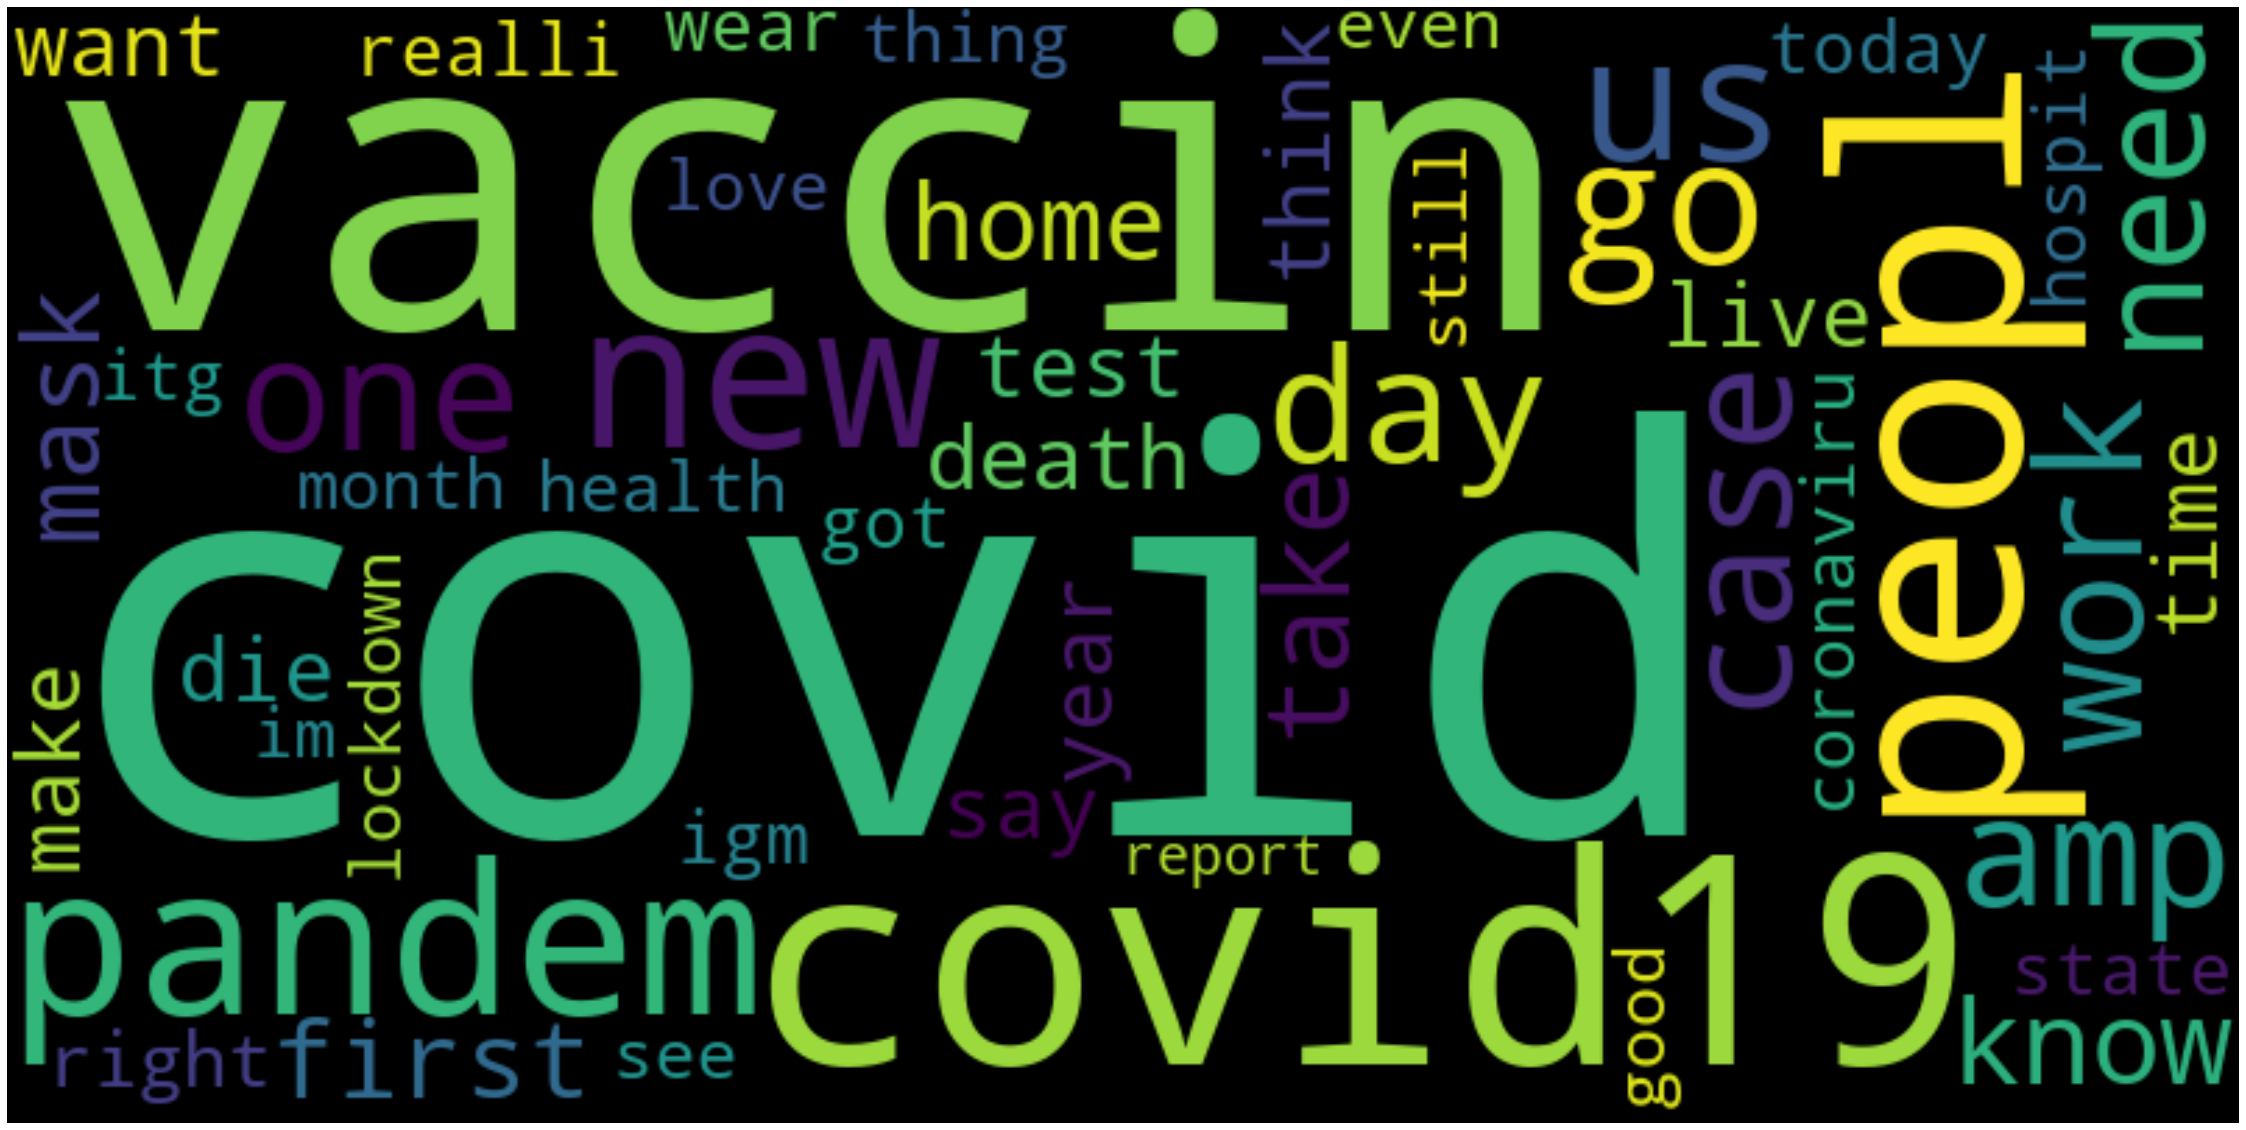

In [89]:
# Import all necesary libraries
string = pd.Series(dataset['tweet']).str.cat(sep=' ')

from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(width=800, height=400,max_font_size=200,max_words=50,collocations=False, background_color='black').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Preparing for Training

#### Before training, and even vectorizing, let's split our data into training and testing sets. It's important to do this before doing anything with the data so we have a fresh test set.

#### Our test size is 0.2, or 20%. This means that X_test and y_test contains 20% of our data which we reserve for testing.


In [90]:
X = dataset.tweet
y = dataset.ProvidedSentimentLabel

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

### Vectorizing Data

#### Let's now fit the vectorizer on the training set only and perform the vectorization.

Just to reiterate, it's important to not fit the vectorizer on all of the data since we want a clean test set for evaluating performance. Fitting the vectorizer on everything would result in data leakage, causing unreliable results since the vectorizer shouldn't know about future data.

We can fit the vectorizer and transform X_train in one step:

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vect = CountVectorizer(max_features=1000, binary=True, ngram_range=(1,2))


#vect = TfidfVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)
print(vect.get_feature_names())

['10', '100', '100000', '100k', '11', '14', '14 million', '15', '19', '1st', '20', '2020', '2021', '24', '2700', '2760', '2nd', '80', '911', 'abl', 'absolut', 'access', 'accord', 'account', 'across', 'across countri', 'activ', 'actual', 'administr', 'ag', 'age', 'ago', 'ahead', 'alert', 'allow', 'almost', 'alon', 'alreadi', 'also', 'alway', 'amaz', 'america', 'american', 'amid', 'amp', 'ang', 'angel', 'angel first', 'announc', 'annual', 'anoth', 'answer', 'antivaxx', 'anybodi', 'anyon', 'anyth', 'apart', 'appar', 'appli', 'approv', 'april', 'arengt', 'around', 'arrest', 'articl', 'artist', 'ask', 'attend', 'australia', 'australian', 'author', 'avail', 'avoid', 'awar', 'award', 'away', 'babi', 'back', 'back better', 'bad', 'bag', 'ban', 'bar', 'bar close', 'bare', 'bc', 'becom', 'bed', 'began', 'begin', 'behind', 'believ', 'benefit', 'best', 'better', 'better toward', 'beyond', 'beyond reason', 'bg', 'biden', 'big', 'biggest', 'bihar', 'bike', 'bill', 'billion', 'biontech', 'bjp', 'blac

### Balancing the Data

#### It seems that there may be a lot more positive sentiments negative positive headlines (hmm), and so we have a lot more negative labels than positive labels.


In [92]:
counts = dataset.ProvidedSentimentLabel.value_counts()
print(counts)

print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))

1    804
0    458
Name: ProvidedSentimentLabel, dtype: int64

Predicting only 1 = 63.71% accuracy


We can see from above, we have slightly more positives than negatives, making our dataset slightly imbalanced.

By calculating if our model only chose to predict 1, the larger class, we would get a ~60% accuracy. This means that in our binary classification model, where random chance is 50%, a 60% accuracy wouldn't tell us much. We would definitely want to look at precision and recall more than accuracy.

We can balance our data by using a form of oversampling called SMOTE. SMOTE looks at the minor class, negatives in our case, and creates new, synthetic training examples. 

Note: We have to make sure we only oversample the train data so we don't leak any information to the test set.

Let's perform SMOTE with the imblearn library:

In [93]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [94]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 645), (1, 645)]


### Training Multimodal Naive Bayes model

In [95]:
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
nb.score(X_train_res, y_train_res)


0.9007751937984496

### Naive Bayes has successfully fit all of our training data and is ready to make predictions. You'll notice that we have a score of ~91%. This is the fit score, and not the actual accuracy score. You'll see next that we need to use our test set in order to get a good estimate of accuracy.

#### Let's vectorize the test set, then use that test set to predict if each test headline is either positive or negative. Since we're avoiding any data leakage, we are only transforming, not refitting. And we won't be using SMOTE to oversample either.

In [96]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])

#### y_pred now contains a prediction for every row of the test set. With this prediction result, we can pass it into an sklearn metric with the true labels to get an accuracy score, F1 score, and generate a confusion matrix:

In [97]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nPrecision Score: {:.2f}".format(precision_score(y_test, y_pred) * 100))
print("\nRecall Score: {:.2f}".format(recall_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 67.19%

F1 Score: 71.86

Precision Score: 77.94

Recall Score: 66.67

COnfusion Matrix:
 [[ 64  30]
 [ 53 106]]


### Naive Bayes classification report and  confusion matrix

In [98]:
print("Classification report")
print(classification_report(y_test, y_pred))



print("Confusion Matrix:")
cm_nb = confusion_matrix(y_test, y_pred)
print(cm_nb)




Classification report
              precision    recall  f1-score   support

           0       0.55      0.68      0.61        94
           1       0.78      0.67      0.72       159

    accuracy                           0.67       253
   macro avg       0.66      0.67      0.66       253
weighted avg       0.69      0.67      0.68       253

Confusion Matrix:
[[ 64  30]
 [ 53 106]]


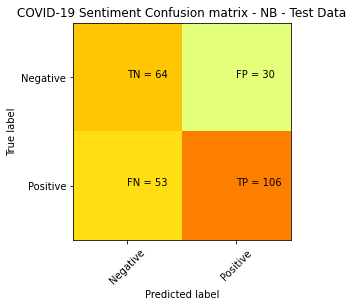

In [99]:
plt.clf()
plt.imshow(cm_nb, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('COVID-19 Sentiment Confusion matrix - NB - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_nb[i][j]))
plt.show()